In [135]:
from stravalib.client import Client
import time
import pandas as pd

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data From Strava

## Web access post reuquest Demo (https://developers.strava.com/docs/getting-started/#oauth)
curl -X POST https://www.strava.com/oauth/token \
    -F client_id=40761 \
    -F client_secret=72638d8c256371fea5e3a90819267d838a7de254 \
    -F code=005352d0601908e4ae3f8748141d14583197feb8 \
    -F grant_type=authorization_code

In [136]:
client = Client()
authorize_url = client.authorization_url(client_id=1234, redirect_uri='http://localhost:8282/authorized')
# Have the user click the authorization URL, a 'code' param will be added to the redirect_uri
# .....

# Extract the code from your webapp response

code = '57e0fff2b106d7dbe92246b35936cdcec9b28b1a'
client_id = 40761
client_secret = '72638d8c256371fea5e3a90819267d838a7de254'


# code = request.get('code') # or whatever your framework does
token_response = client.exchange_code_for_token(client_id=client_id, client_secret=client_secret, code=code)
access_token = token_response['access_token']
refresh_token = token_response['refresh_token']
expires_at = token_response['expires_at']

# Now store that short-lived access token somewhere (a database?)
client.access_token = access_token
# You must also store the refresh token to be used later on to obtain another valid access token 
# in case the current is already expired
client.refresh_token = refresh_token

# An access_token is only valid for 6 hours, store expires_at somewhere and
# check it before making an API call.
client.token_expires_at = expires_at
print(f'expires at: {expires_at}')
 
athlete = client.get_athlete()
print("For {id}, I now have an access token {token}".format(id=athlete.id, token=access_token))

if time.time() > client.token_expires_at:
    refresh_response = client.refresh_access_token(client_id=1234, client_secret='asdf1234',
        refresh_token=client.refresh_token)
    access_token = refresh_response['access_token']
    refresh_token = refresh_response['refresh_token']
    expires_at = refresh_response['expires_at']

expires at: 1573740692
For 23066318, I now have an access token c0cb83df4e253400baf3a3ecf5beb9c7453e5118


## Get some stats on current athlete (me)

In [137]:
client =  Client(access_token=access_token)

In [138]:
print("Hello, {}".format(athlete.firstname))

Hello, Nate


In [139]:
for activity in client.get_activities(after = "2010-01-01T00:00:00Z",  limit=5):
    print("{0.name} {0.moving_time}".format(activity))

Keystone Day 4 3:24:42
Eldora XC skiing 1:58:05
Muddy run w/ Zach 0:56:00
New Albany 0:23:24
Gahanna / New Albany 0:31:45


In [140]:
activity_raw = client.get_activities(limit=1000)

In [141]:
activities = list(activity_raw)

In [142]:
print(len(activities))

152


### Filter On PCT

In [143]:
# Could do a regex to make this more accurate
pct_raw = [a for a in activities if a.name.startswith('Day ')]
pct_raw.reverse()
print([n.name for n in pct_raw[0:5]])

['Day 1 - Campo to Lake Morena', 'Day 2 - Lake Morena to Mount Laguna', 'Day 3 - Mount Laguna to mi. 64', 'Day 4 - mi. 64 to Scissors Crossing', 'Day 6 - Scissors Crossing to Chery’s']


## Data Test

In [172]:
pct = {
    'elev_high' : [a.elev_high for a in pct_raw],
    'elev_low' :  [a.elev_low for a in pct_raw],
    'km': [float(a.distance / 1000) for a in pct_raw],
    'label': [a.name for a in pct_raw],
}
pct = pd.DataFrame.from_dict(pct).dropna()
pct.head()

,elev_high,elev_low,km,label
0,1075.2,720.2,32.0125,Day 1 - Campo to Lake Morena
1,1833.2,916.4,36.4034,Day 2 - Lake Morena to Mount Laguna
2,1842.6,1198.2,33.7508,Day 3 - Mount Laguna to mi. 64
3,1321.4,698.2,20.9330,Day 4 - mi. 64 to Scissors Crossing
4,1311.2,683.8,39.5964,Day 6 - Scissors Crossing to Chery’s


In [173]:
bad_data_filter = pct.elev_high - pct.elev_low > 5000
print(f'Dropping Bad Data: {pct[bad_data_filter]}')
pct = pct[~bad_data_filter]

Dropping Bad Data:     elev_high  elev_low      km                      label
54     4998.6    -500.0  47.436  Day 63 - mi 147 to mi 178


In [174]:
#  Note: Added the "if" condition because there seems to be a bad day
y_plot_data = [(y_min, y_max) for y_min, y_max  in zip(pct.elev_low, pct.elev_high)]

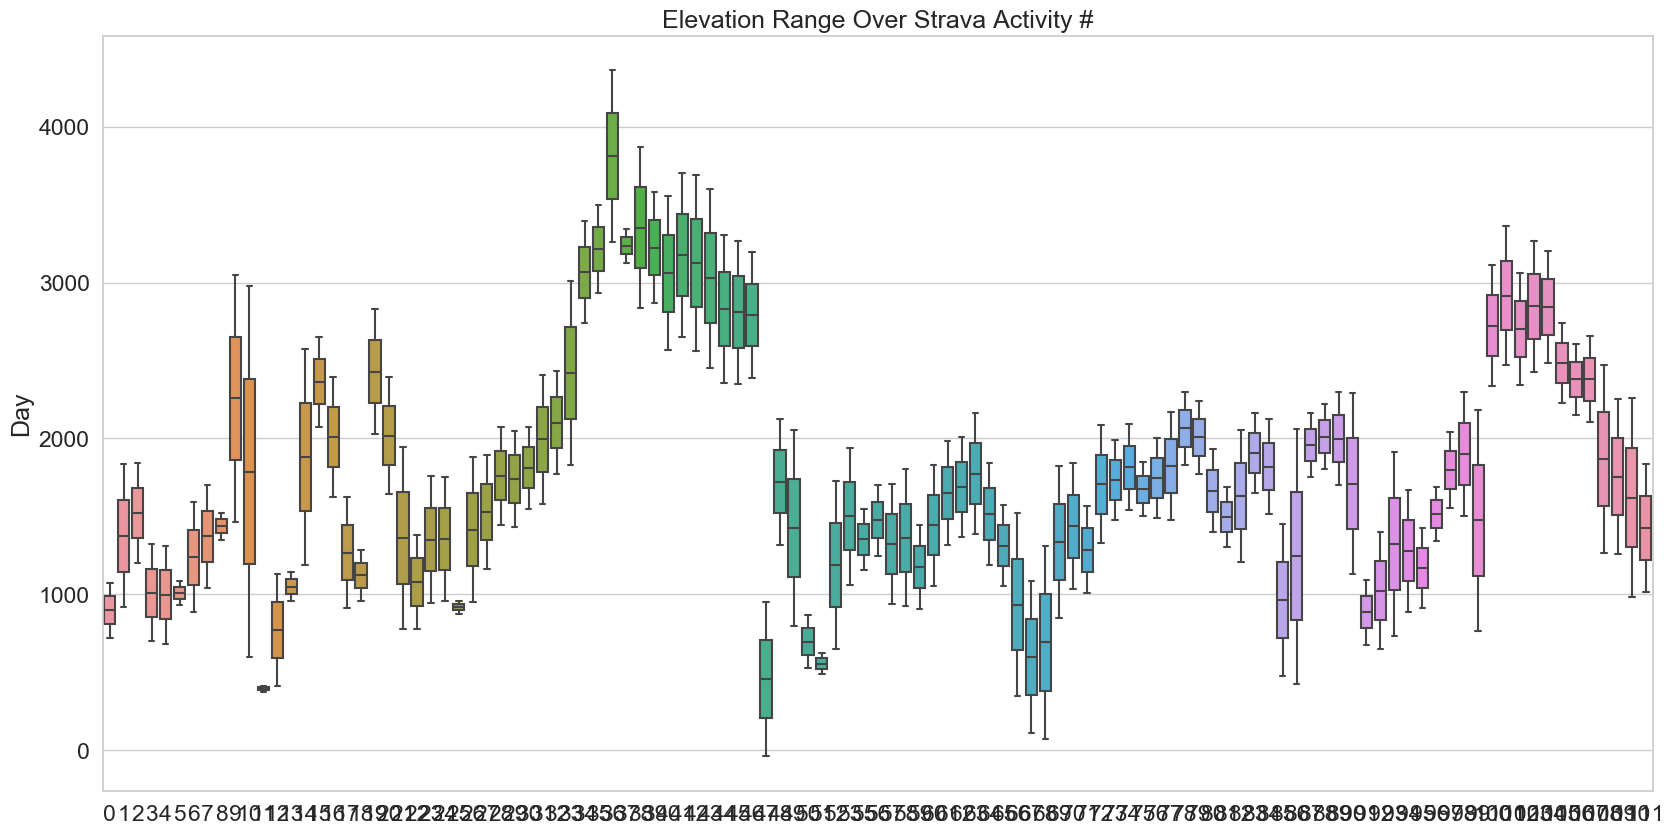

In [175]:
f, axarr = plt.subplots(figsize=(20, 10), dpi=100)
sns.boxplot(x=pct.index, y=y_plot_data)
plt.title('Elevation Range Over Strava Activity #')
axarr.set_ylabel('Meters')
axarr.set_ylabel('Day')
plt.show()

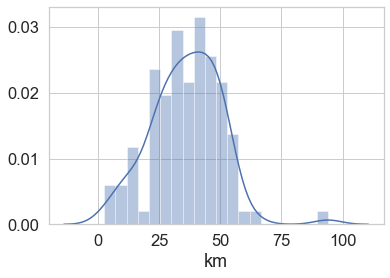

In [177]:
sns.distplot(pct.km, bins=20)

In [192]:
km_to_mi = 0.621371
total_pct_miles = 2663
mpd = pct.km.mean() * 0.621371
total_distance_mi = sum(pct.km) * 0.621371
bias = total_distance_mi / total_pct_miles

print(f'Miles Per Day: {mpd:.2f}')
print(f'Total Measured Distance: {total_distance_mi:g}')
print(f'Real Distance: {total_pct_miles}')
print(f'Recording Bias: {bias*100:0.2f}% of total mileage recorded')


Miles Per Day: 22.40
Total Measured Distance: 2486.48
Real Distance: 2663
Recording Bias: 93.37% of total mileage recorded
